# LSTM: The basics

In this notebook, we will learn the basics of a Long Short Term Memory (LSTM) based on [Keras](https://keras.io/), a high-level API for building and training deep learning models, running on top of [TensorFlow](https://www.tensorflow.org/), an open source platform for machine learning. 

We will build a basic LSTM to predict stock prices in the future. The data is provided in your training environment - but in future you can also access it in [this github repo](https://github.com/mwitiderrick/stockprice).

### Contents

1. [Converting and preparing data](#convert_data)
2. [A multi-variate LSTM](#simple_lstm)

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

plt.style.use('ggplot')

## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


<a id='convert_data'></a>
## Converting data to sequence structure


One of the critical features of $RNNs$ and $LSTMs$ is that they work on sequences of data. In the lecture notes we saw that the network takes input at a time $t$ and the hiden layer state from $t-1$ and produces an output:

<img src="https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/lstms-1.png?raw=1" alt="lstms-1" width="500"/>

However we may also want to include measured data from further back in time to help with remembering; so we could want input data from $t-1 \cdots t-n$. We might also have more than one channel of input data, this is called the  **window** of the data. Imagine for example we were predicting stock prices, we could have the history of that stock, but we might also want to know the central bank interest rate, or the strength of one currency relative to another, in this case we have a **multi-variate** problem. So our input data looks more like:

<img src="https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/lstms-2.png?raw=1" alt="lstms-2" width="500"/>


Also, we might also want to make our $LSTM$ predict more than just one step forward, so we will want to be able to have multiple steps in the output.

We write a function to convert dataframe series into data that is suitable for $LSTM$ training. This function is quite flexible and can be useful in many scenarios, so it is one that you might like to reuse in future if you are training time series models.

As input we pass the data as a `numpy` array. We then also specify how far back in time we wish to look for each prediction `n_in`, so `n_in = 1` means we take just $t$ as input, `n_in=2` means we take $t, t-1$ as input and so on. We specify how far into the future we wish to predict, with the `n_out` variable. `n_out=1` means we predict for $t$, `n_out=2` means we predict for $t, t+1$ and so on. In addition to the window sizes, we can also select the features (columns in the data) to use with the `feature_indices` argument. 

The series data can be infinitely long while the memory of our LSTM cannot not be infinitely large. Therefore, we need to specify the length of the LSTM, or the `timesteps`, which is usually much smaller than the total length of the series. The first dimension of the outputs (`X` and `y` for `TensorFlow`) is `batch`; time-dependency is ignored among the batches (i.e., they can be shuffled).

In [4]:
def series_to_tensorflow(data, timesteps=10, n_in=1, n_out=1, feature_indices=None):
    """
    Convert a series to tensorflow input.
    Arguments:
       data: Sequence of observations as a 2D NumPy array of shape (n_times, n_features)
       n_in: Window size of input X
       n_out: Window size of output y
       feature_indices: select features by indices; pass None to use all features
       timesteps: timesteps of LSTM
    Returns:
       X and y for tensorflow.keras.layers.LSTM
    """
    # sizes
    n_total_times, n_total_features = data.shape[0], data.shape[1]
    n_batches = n_total_times - timesteps - (n_in - 1) - (n_out - 1)
    
    # feature selection
    if feature_indices is None:
        feature_indices = list(range(n_total_features))
    
    # data
    X = np.zeros((n_batches, timesteps, n_in, len(feature_indices)), dtype='float32')
    y = np.zeros((n_batches, n_out, len(feature_indices)), dtype='float32')
    for i_batch in range(n_batches):
        for i_in in range(n_in):
            X_start = i_batch + i_in
            X[i_batch, :, i_in, :] = data[X_start:X_start + timesteps, feature_indices]
        y_start = i_batch + timesteps + n_in - 1
        y[i_batch, :, :] = data[y_start:y_start + n_out, feature_indices]
    
    # flatten the last two dimensions
    return X.reshape(n_batches, timesteps, -1), y.reshape(n_batches, -1)

<a id='simple_lstm'></a>

## A multi-variate LSTM

### Importing and treating the data

We first read in our data and inspect it using `pandas`.


In [5]:
# Importing the training set
dataset_train = pd.read_csv(data_path + '/lstm-data/data-train-lstm.csv')
training_set = dataset_train.iloc[:, 1:2].values

In [6]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [7]:
print(f'Dimensions of raw data: (n_times, n_features) = {dataset_train.shape}')

Dimensions of raw data: (n_times, n_features) = (2035, 8)


In the next cell, we get rid of the `Date` column (the first column) and normalize the rest price columns to `[0, 1]` using `MinMaxScaler` from `scikit-learn`.

In [8]:
# drop `Date` column
values = dataset_train.drop(dataset_train.columns[[0,]], axis=1).values

# normalize prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [9]:
print(f'Dimensions of normalized price data: (n_times, n_features) = {scaled.shape}')

Dimensions of normalized price data: (n_times, n_features) = (2035, 7)


### Converting to $LSTM$ structure data


We now want to convert the data to a structure that can be fed to the $LSTM$. To do this we use our `series_to_tensorflow` function. In this case, we use 80 as the `timesteps`, looking back 8 steps (`n_in=8`) and projecting forward 4 steps (`n_out=4`) and considering the `Open` and `Close` prices (i.e., `feature_indices=[0, 4]`). 

In [10]:
timesteps = 80
n_in = 8
n_out = 4
feature_indices = [0, 4]

X_train, y_train = series_to_tensorflow(scaled, timesteps=timesteps, 
                                        n_in=n_in, n_out=n_out, feature_indices=feature_indices)
print(f'Dimensions of X_train: (batches, timesteps, features) = {X_train.shape}')
print(f'Dimensions of y_train: (batches, features) = {y_train.shape}')

Dimensions of X_train: (batches, timesteps, features) = (1945, 80, 16)
Dimensions of y_train: (batches, features) = (1945, 8)


### Building the network
<a id='build_lstm'></a>

Note that as before we start off from a `Sequential` type model in `Keras`.

The $LSTM$ layers are already coded in `Keras` so we do not need to worry about writing the complicated structure. We just need to consider a few hyper-parametes we want to set,

* Number of LSTM layers - we can stack LSTM layers in this case we will start with 2 stacked LSTMs;
* units - this is the dimensionality of the hidden state and memory cell of the LSTM;
* return_sequences - should we return the full output sequence or just the final value in the sequence. Generally, if the LSTM layer is feeding to another layer in the network, this would be `True`; if the LSTM layer is the final layer then this is `False`; note default is `False`.

In [11]:
# Initialising the LSTM
regressor = Sequential()

# Adding the first LSTM layer
# shape: (N, 80, 16) => (N, 80, 50)
regressor.add(LSTM(units=50, return_sequences=True, dropout=0.4,
                   input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding a second LSTM layer
# shape: (N, 80, 24) => (N, 24)
regressor.add(LSTM(units=24, return_sequences=False, dropout=0.4,))

# Adding an output layer 
# shape: (N, 24) => (N, 8)
regressor.add(Dense(units=y_train.shape[1]))

### Compile the network

As ususal we need to compile the network, choosing an optimiser and a loss function. 

We use `adam` as our optimiser and `mean_squared_error` as our loss.

In [12]:
# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

### Train the network

In [13]:
# Fitting the RNN to the Training set
history = regressor.fit(X_train, y_train, epochs=30, batch_size=128)

Epoch 1/30
16/16 [==============================] - 4s 70ms/step - loss: 0.0421
Epoch 2/30
16/16 [==============================] - 1s 68ms/step - loss: 0.0093
Epoch 3/30
16/16 [==============================] - 1s 67ms/step - loss: 0.0049
Epoch 4/30
16/16 [==============================] - 1s 63ms/step - loss: 0.0036
Epoch 5/30
16/16 [==============================] - 1s 78ms/step - loss: 0.0032
Epoch 6/30
16/16 [==============================] - 1s 67ms/step - loss: 0.0030
Epoch 7/30
16/16 [==============================] - 1s 69ms/step - loss: 0.0028
Epoch 8/30
16/16 [==============================] - 1s 65ms/step - loss: 0.0028
Epoch 9/30
16/16 [==============================] - 1s 65ms/step - loss: 0.0026
Epoch 10/30
16/16 [==============================] - 1s 65ms/step - loss: 0.0025
Epoch 11/30
16/16 [==============================] - 1s 65ms/step - loss: 0.0025
Epoch 12/30
16/16 [==============================] - 1s 68ms/step - loss: 0.0026
Epoch 13/30
16/16 [==================

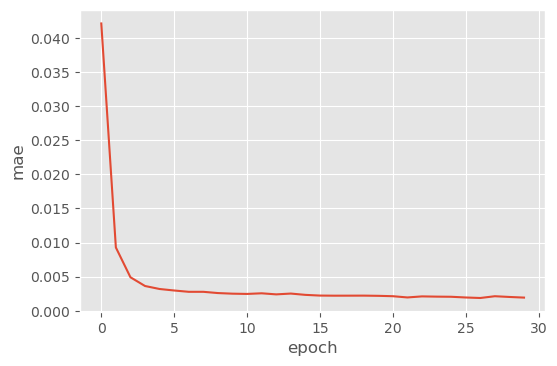

In [14]:
plt.figure(dpi=100)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

### Making predictions with our model

We now use model that we just built to predict on previously un-seen data. We read in `data-test.csv` and get the stock prices from that data.


In [15]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = pd.read_csv(data_path + 'lstm-data/data-test-lstm.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values
print(dataset_test.shape)

(16, 8)


In [16]:
dataset_test.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-24,220.10,221.25,217.05,219.55,219.80,2171956,4771.34
1,2018-10-23,221.10,222.20,214.75,219.55,218.30,1416279,3092.15
2,2018-10-22,229.45,231.60,222.00,223.05,223.25,3529711,8028.37
3,2018-10-19,230.30,232.70,225.50,227.75,227.20,1527904,3490.78
4,2018-10-17,237.70,240.80,229.45,231.30,231.10,2945914,6961.65


The testing data contain 16 time steps. We will concatenate them to the training data for time extension. 

In [17]:
# Getting the predicted stock price of 2017
dataset_extended = pd.concat((dataset_train, dataset_test), axis=0)
values_extended = dataset_extended.drop(dataset_extended.columns[[0,]], axis=1).values
scaled_extended = scaler.transform(values_extended)
print(f'Dimensions of normalized price data: (n_times, n_features) = {scaled_extended.shape}')

Dimensions of normalized price data: (n_times, n_features) = (2051, 7)


In [18]:
# using the last points to generate testing data
X_test, y_test = series_to_tensorflow(scaled_extended[-(timesteps + n_in + n_out - 2 + len(dataset_test)):], 
                                      timesteps=timesteps,
                                      n_in=n_in, n_out=n_out, feature_indices=feature_indices)

# make predictions
y_pred = regressor(X_test)
print(f'Dimensions of X_test: (batches, timesteps, features) = {X_test.shape}')
print(f'Dimensions of y_test: (batches, features) = {y_test.shape}')
print(f'Dimensions of y_pred: (batches, features) = {y_pred.shape}')

Dimensions of X_test: (batches, timesteps, features) = (16, 80, 16)
Dimensions of y_test: (batches, features) = (16, 8)
Dimensions of y_pred: (batches, features) = (16, 8)


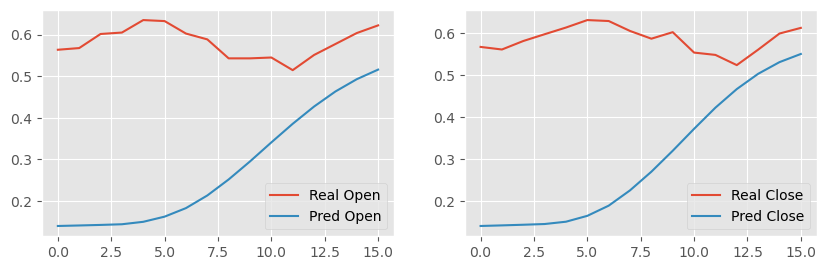

In [19]:
# Visualising the results
fig, ax = plt.subplots(1, len(feature_indices), dpi=100, 
                       figsize=(5 * len(feature_indices), 3), squeeze=False)
for i, index in enumerate(feature_indices):
    # we are ploting the last point from the output window
    ax[0, i].plot(y_test[:, i + (n_out - 1) * len(feature_indices)], 
                  label = 'Real ' + dataset_train.keys()[index + 1])
    ax[0, i].plot(y_pred[:, i + (n_out - 1) * len(feature_indices)], 
                  label = 'Pred ' + dataset_train.keys()[index + 1])
    ax[0, i].legend()
plt.show()

### Exercise

* Build a network with three or four $LSTM$ layers. How does this affect the performance?
* Change the LSTM timesteps (`timesteps`) - how does a longer/shorter one affect the predictions?
* Try other window sizes and features.
